# Network Analysis of The International 2021 - Playoffs Teams

## Dataset: Fase Eliminatória do The International 11

O International é o maior evento competitivo de Dota 2 e um dos eventos de e-sports mais bem pagos do mundo. Esse evento anual reúne as melhores equipes de Dota 2 do mundo para competir pelo título e premiação de milhões de dólares.
Nesta análise, verificaremos como as equipes se saíram umas contra as outras na edição de 2021, bem como medidas de análise de rede, como betweness centrality, weight degree, comunidades, etc.

* Os nós são os times;
* As arestas são as partidas disputadas entre os times. A seta da aresta surge do time que ganhou e aponta para o derrotado.

### Instala NetworkX e Pyvis

In [148]:
!pip install networkx
!pip install pyvis

### Importa as bibliotecas

In [149]:
import os
import networkx as nx
import pandas as pd
#pd.set_option('max_rows', 400)
from networkx.algorithms import community
import matplotlib.pyplot as plt
from pyvis.network import Network

# Eliminatórias: Carrega dataset

In [150]:
df = pd.read_csv('network_analysis/data/TheInternational/TI_2021/Playoffs Main Event Matches.csv', index_col=1)
df

,Unnamed: 0,Team1,Score1,Team2,Score2
Round,,,,,
Upper Bracket R1 (Bo3),0,Invictus Gaming,2,Team Spirit,1
Upper Bracket R1 (Bo3),1,Team Secret,2,OG,0
Upper Bracket R1 (Bo3),2,PSG.LGD,2,T1,1
Upper Bracket R1 (Bo3),3,Virtus.pro,2,Vici Gaming,1
Upper Bracket R2 (Bo3),4,Invictus Gaming,0,Team Secret,2
Upper Bracket R2 (Bo3),5,PSG.LGD,2,Virtus.pro,0
Upper Bracket Final (Bo3),6,Team Secret,0,PSG.LGD,2
Lower Bracket R1 (Bo1),7,Team Undying,0,Fnatic,1
Lower Bracket R1 (Bo1),8,Quincy Crew,1,Team Aster,0


## Exibindo o grafo (direcionado)
A seta surge do time vitorioso e aponta para o time que foi derrotado.

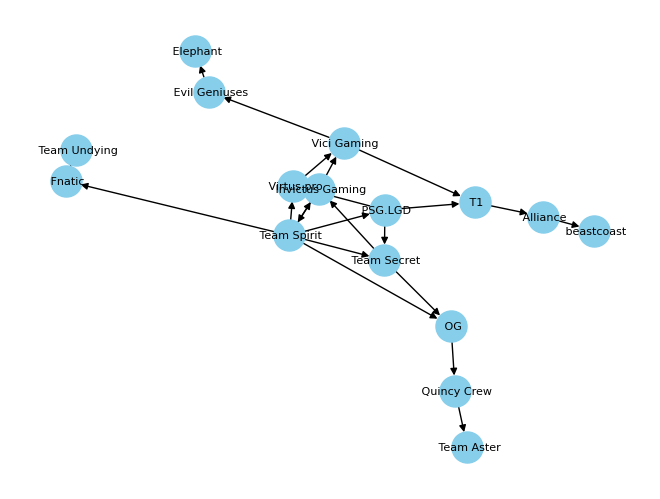

In [151]:
# Cria um grafo direcionado
G = nx.DiGraph()

# Adiciona nós para cada time
teams = set(df['Team1']).union(set(df['Team2']))
for team in teams:
  G.add_node(team)

# Adiciona arestas representando as partidas vencidas
for index, row in df.iterrows():
  team1 = row['Team1']
  team2 = row['Team2']
  score1 = int(row['Score1'])
  score2 = int(row['Score2'])
  if score1 > score2:
    G.add_edge(team1, team2)
  else:
    G.add_edge(team2, team1)

# Desenha o grafo
nx.draw(G, with_labels=True, node_size=500, node_color="skyblue", font_size=8)

## Salvando o Arquivo do Grafo

In [ ]:
nx.write_graphml(G, 'TI11 Playoffs Teams.graphml')

## Degree
O número de conexões que um nó possui.
Cria um dataframe e o exibe.

In [152]:
# Make the degree values a `dict`ionary, then add it as a network "attribute" with `networkx.set_node_attributes()`
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

degree_df = pd.DataFrame(G.nodes(data='degree'), columns=['node', 'degree'])
degree_df = degree_df.sort_values(by='degree', ascending=False)
degree_df

,node,degree
1,Team Spirit,7
8,PSG.LGD,4
12,Invictus Gaming,4
13,Vici Gaming,4
15,Team Secret,4
0,T1,3
3,OG,3
6,Virtus.pro,3
2,Evil Geniuses,2
4,Quincy Crew,2


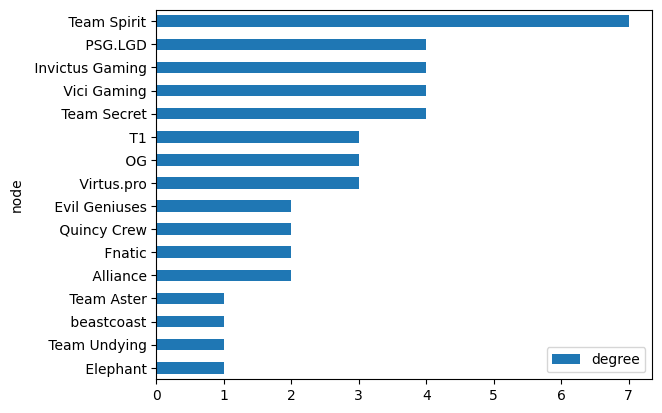

In [153]:
num_nodes_to_inspect = 16
degree_df[:num_nodes_to_inspect].plot(x='node', y='degree', kind='barh').invert_yaxis()

## Matriz de Adjacência
A matriz de adjacência é uma representação do grafo em formato de matriz.
Cada linha e coluna representa um time, e o valor na célula indica se existe uma partida entre eles.

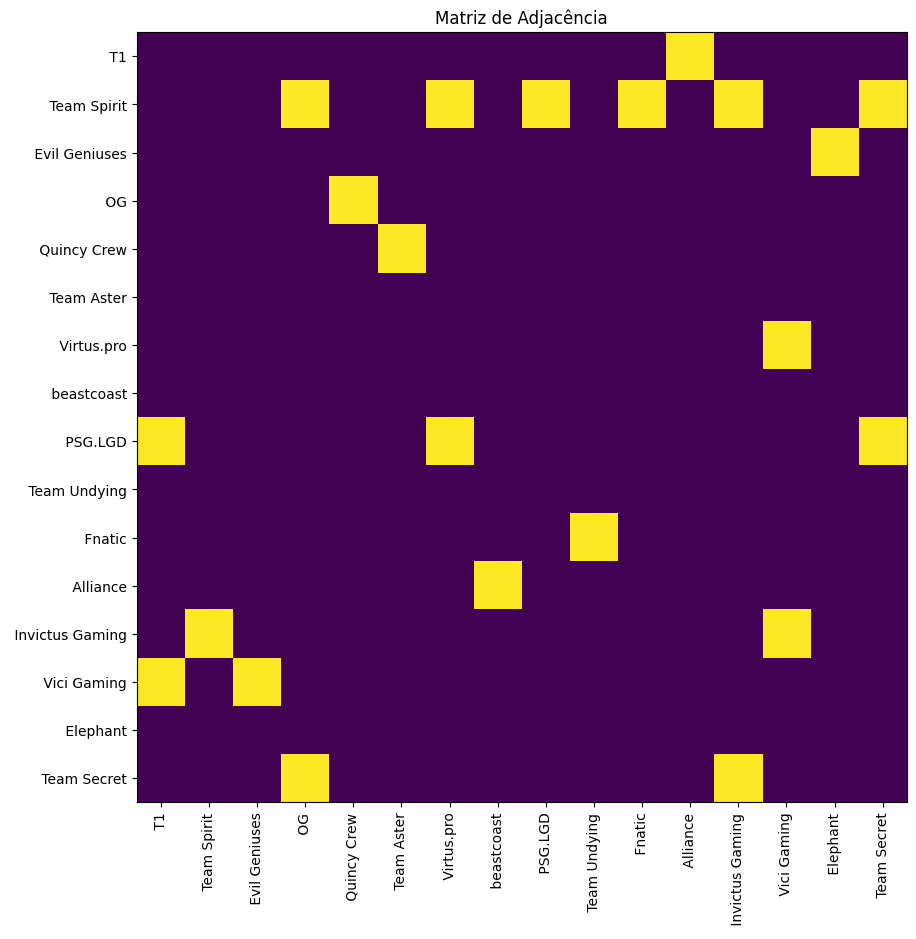

In [161]:
# Cria a matriz
adjacency_matrix = nx.to_numpy_array(G)

# Configs
plt.figure(figsize=(10, 10))
plt.imshow(adjacency_matrix, cmap='viridis', interpolation='nearest')

# Labels dos times
tick_marks = range(len(G.nodes()))
plt.xticks(tick_marks, G.nodes(), rotation=90)
plt.yticks(tick_marks, G.nodes())

# Plota!
plt.title("Matriz de Adjacência")
plt.show()


## Diâmetro e periferia da rede:

Diâmetro e periferia da rede:
Analisando o grafo podemos ver que o diâmetro é 8, ou seja, 8 é a maior distância entre quaisquer dois vértices do grafo.

Observando os valores da periferia temos os dois vértices('PSG.LGD' e 'Team Secret') que estão a uma distância máxima dos demais vértices do grafo.

In [ ]:
# Identificando subgrafos conectados na rede
strongs = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
subgrafos = [G.subgraph(s) for s in strongs]

# Verificando a quantidade de subgrafos
print("Quantidade de Subgrafos na rede: ", len(subgrafos))

# Diâmetro
print ("Diametro:", nx.diameter(subgrafos[0]))

# Periferia
print ("Periferia do subgrafo escolhido: ", nx.periphery(subgrafos[0]))

Quantidade de Subgrafos na rede:  13
Diametro: 3
Periferia do subgrafo escolhido:  [' PSG.LGD', ' Team Secret']


## Histograma de distribuição empírica de grau
Observando o histograma é possivel ver a presença de vértices de alto grau, ou seja, alguns vértices têm um número muito maior de arestas do que a média. Dessa forma, podemos perceber a presença de "hubs"( vértices altamente conectados ) no grafo.

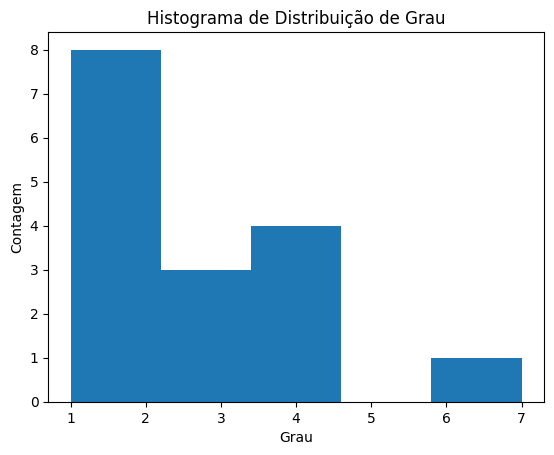

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

# Plota o histograma
plt.hist(degree_sequence, bins='auto')
plt.title("Histograma de Distribuição de Grau")
plt.ylabel("Contagem")
plt.xlabel("Grau")
plt.show()


## Assortatividade geral da rede:
Valores positivos do coeficiente de assortatividade indicam uma correlação entre nós de grau semelhante, enquanto valores negativos indicam relações entre nós de grau diferente. Dessa forma, temos o valor negativo -0.32 indicando a desassortatividade do grafo.

In [ ]:
nx.degree_assortativity_coefficient(G)

0.3239891110814974

## Coeﬁciente de clustering local para nós escolhidos:
- Como sabemos o coeficiente de clustering local varia de 0 a 1. Um valor próximo a 0 indica que os vizinhos do vértice estão pouco conectados entre si, formando poucos agrupamentos. Por outro lado, um valor próximo a 1 indica que os vizinhos do vértice estão altamente conectados entre si, formando agrupamentos densos.

Foram escolhidos três vértices para calcular o coeﬁciente de clustering local:

*   Alliance - Os vizinhos do vértice não estão conectados entre si. Justificando assim o valor de 0.
*   PSG.LGD - Os vizinhos do vértice também estão muito pouco conectados entre si, coeficiente de 0.16;
*   Team Secret -  Os vizinhos deste vértice são os mais conectados entre si de todo o gráfico, tendo um valor de 0.33.

In [ ]:
nodes = [' Team Secret', ' PSG.LGD', ' Alliance']
for node in nodes:
  print(f'Coeficiente de clustering para{node}: {nx.clustering(G, node)}')


Coeficiente de clustering para Team Secret: 0.3333333333333333
Coeficiente de clustering para PSG.LGD: 0.16666666666666666
Coeficiente de clustering para Alliance: 0


## Coeﬁciente de clustering global:
Ao medir o clustering global analizamos a média aritmética dos coeﬁcientes de clusterização de cada vértice.
No grafo G o valor do clustering global é 0.072. Dessa forma, podemos perceber que os vértices do grafo estão fracamente conectados entre si.

In [ ]:
nx.average_clustering(G)

0.07239583333333334

## Componentes Conectados Fortemente:

Ocorre quando em um subgrafo todos os nós se acessam. No caso do grafo G temos 13 components fortemente conectados. Essa métrica permite identificar os clusters da rede.


In [ ]:
print('Quantidade:', nx.number_strongly_connected_components(G))

print("\nComponentes: ")
for component in nx.strongly_connected_components(G):
  print(component)

Quantidade: 13

Componentes: 
{' Elephant'}
{' Evil Geniuses'}
{' beastcoast'}
{' Alliance'}
{' T1'}
{' Vici Gaming'}
{' Virtus.pro'}
{' Team Aster'}
{' Quincy Crew'}
{' OG'}
{' Team Undying'}
{' Fnatic'}
{' Invictus Gaming', ' PSG.LGD', ' Team Secret', ' Team Spirit'}


## Componentes Conectados Fracamente:

Componentes conectados fracamente são subgrafos de um grafo direcionado no qual todos os vértices são conectados por algum caminho, independentemente da direção da aresta. No grafo temos 1 componente.

In [ ]:
print('Quantidade:', nx.number_weakly_connected_components(G))

for component in nx.weakly_connected_components(G):
  print(component)

Quantidade: 1
{' Invictus Gaming', ' Virtus.pro', ' Alliance', ' Team Aster', ' Vici Gaming', ' Team Spirit', ' Team Undying', ' Fnatic', ' Quincy Crew', ' PSG.LGD', ' Evil Geniuses', ' Team Secret', ' Elephant', ' OG', ' beastcoast', ' T1'}


## Eigenvector centrality:
A centralidade de eigenvector mede a importância de um vértice com base em suas conexões com vértices de alto grau, destacando a relevância dessas conexões. No grafo G, o vértice ‘Vici Gaming’ possui a maior centralidade de eigenvector.

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(G)
eigenvector_centrality_sorted = dict(sorted(eigenvector_centrality.items(), key=lambda item: item[1],reverse=True))

eigenvector_centrality_sorted

{' Vici Gaming': 0.3923654887139571,
 ' T1': 0.37016110707724337,
 ' Invictus Gaming': 0.3224684081200986,
 ' OG': 0.3224684081200986,
 ' Evil Geniuses': 0.2677218036204042,
 ' Virtus.pro': 0.25257132752624006,
 ' Team Secret': 0.25257132752624006,
 ' Alliance': 0.25257093772873734,
 ' Quincy Crew': 0.2200291046632594,
 ' Team Spirit': 0.2200291046632594,
 ' Elephant': 0.18267385713487877,
 ' beastcoast': 0.1723330924273411,
 ' PSG.LGD': 0.15013202406940085,
 ' Team Aster': 0.15013202406940085,
 ' Fnatic': 0.15013202406940085,
 ' Team Undying': 0.10243932511225605}

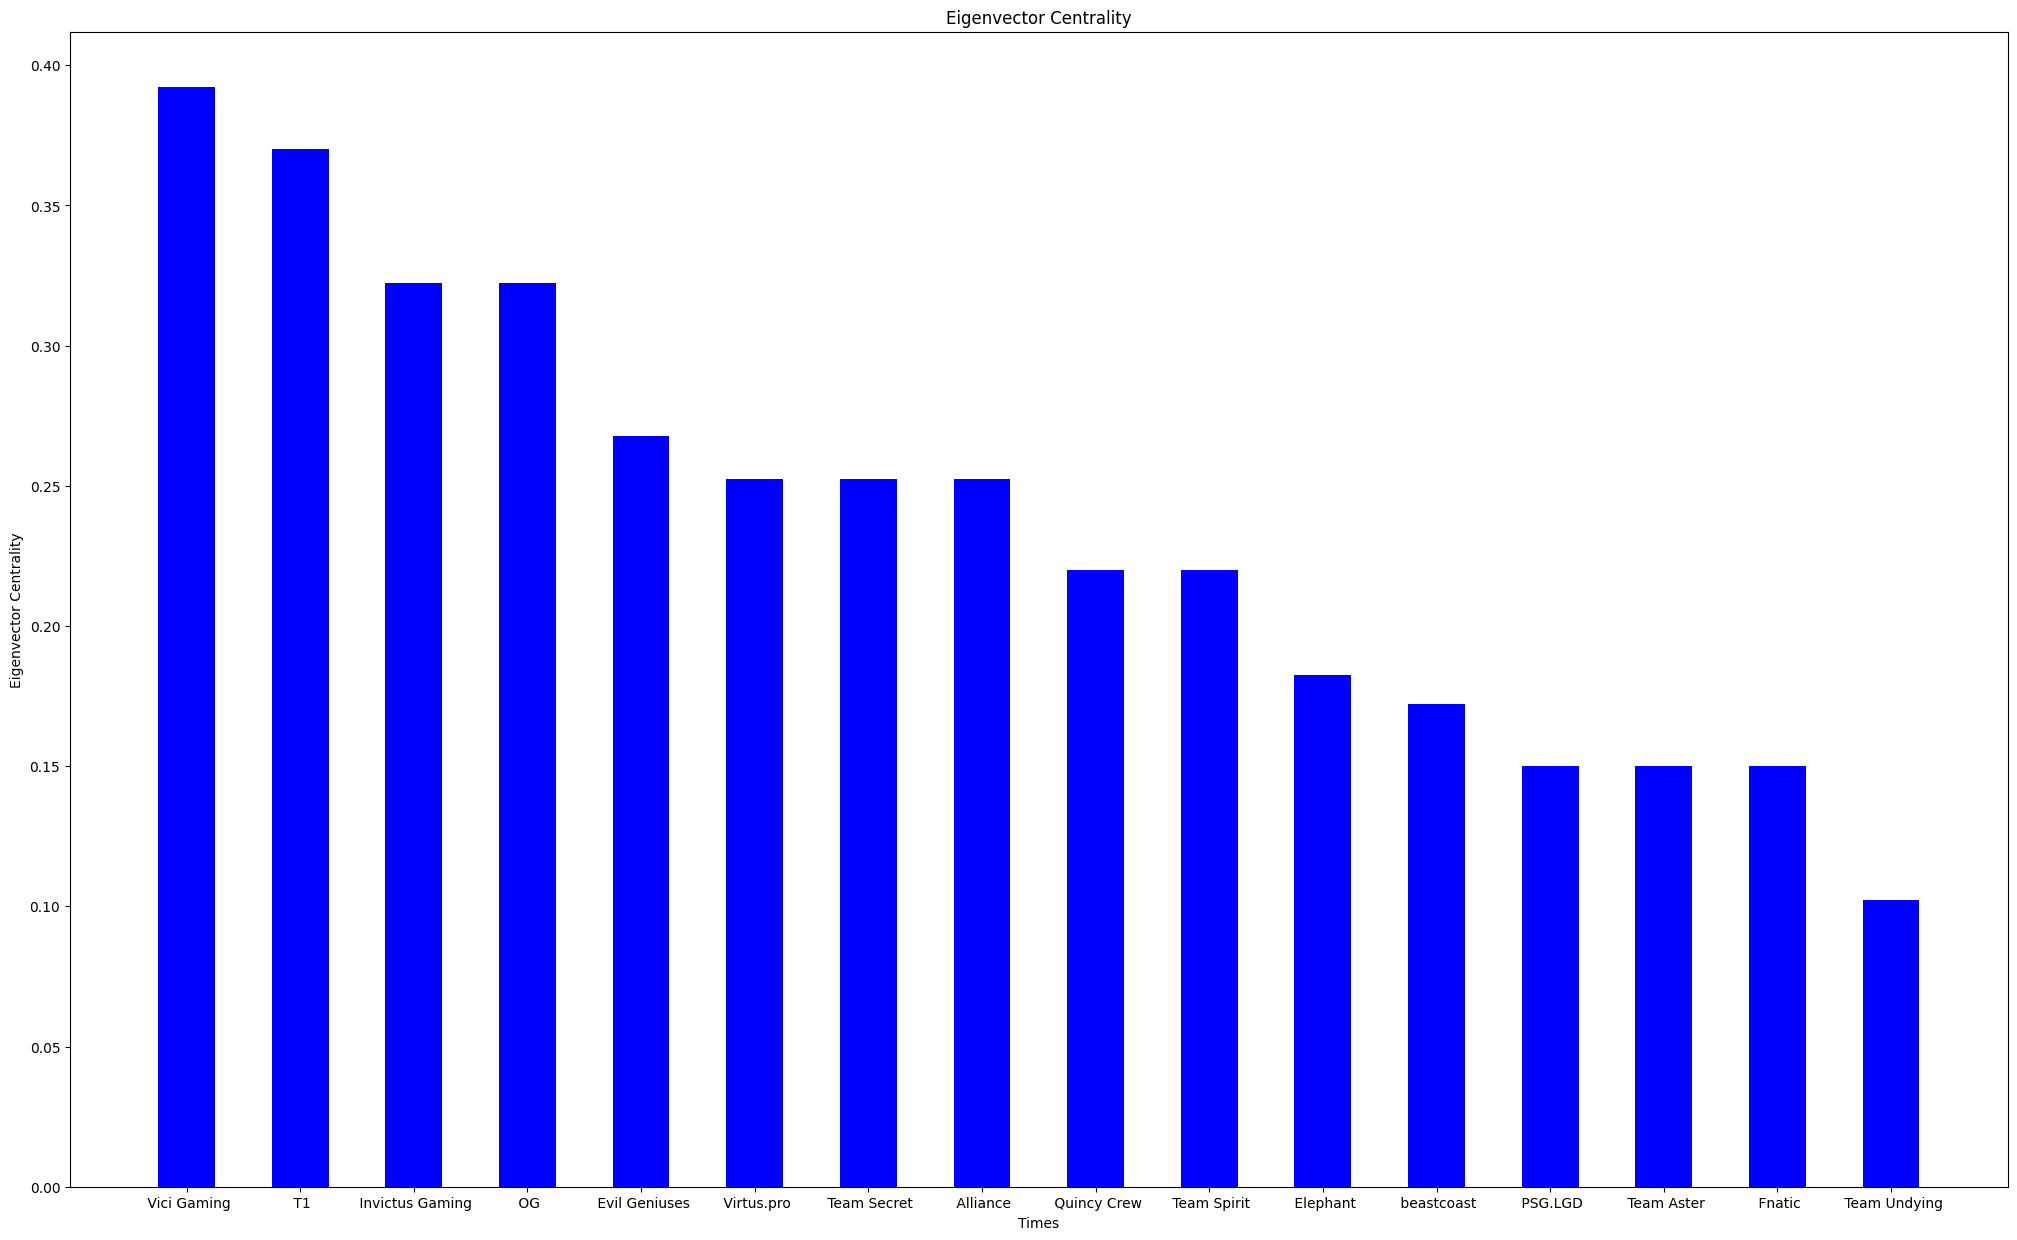

In [ ]:
times = list(eigenvector_centrality_sorted.keys())
values = list(eigenvector_centrality_sorted.values())

fig = plt.figure(figsize = (25, 15))

plt.bar(times, values, color = 'blue',
        width = 0.5)

plt.xlabel("Times")
plt.ylabel("Eigenvector Centrality")
plt.title("Eigenvector Centrality")
plt.show()

## Closeness centrality:

Closeness centrality mede a distância média de um vértice para todos os outros vértices no grafo.

No contexto do The International 11, um time com alta closeness centrality, como o Team Spirit, teve um bom desempenho geral no torneio, com vitórias contra vários outros times. Isso indica que eles foram capazes de derrotar uma variedade de oponentes e tiveram um caminho relativamente curto para a vitória.

In [ ]:
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality_sorted = dict(sorted(closeness_centrality.items(), key=lambda item: item[1],reverse=True))

closeness_centrality_sorted

{' T1': 0.21818181818181817,
 ' Vici Gaming': 0.20833333333333331,
 ' Alliance': 0.1814814814814815,
 ' OG': 0.17777777777777776,
 ' Evil Geniuses': 0.17142857142857143,
 ' beastcoast': 0.1641025641025641,
 ' Elephant': 0.15555555555555556,
 ' Virtus.pro': 0.15238095238095237,
 ' Quincy Crew': 0.1515151515151515,
 ' Team Secret': 0.15000000000000002,
 ' Invictus Gaming': 0.15000000000000002,
 ' Team Aster': 0.14117647058823532,
 ' Team Undying': 0.1111111111111111,
 ' Fnatic': 0.10666666666666667,
 ' PSG.LGD': 0.1,
 ' Team Spirit': 0.1}

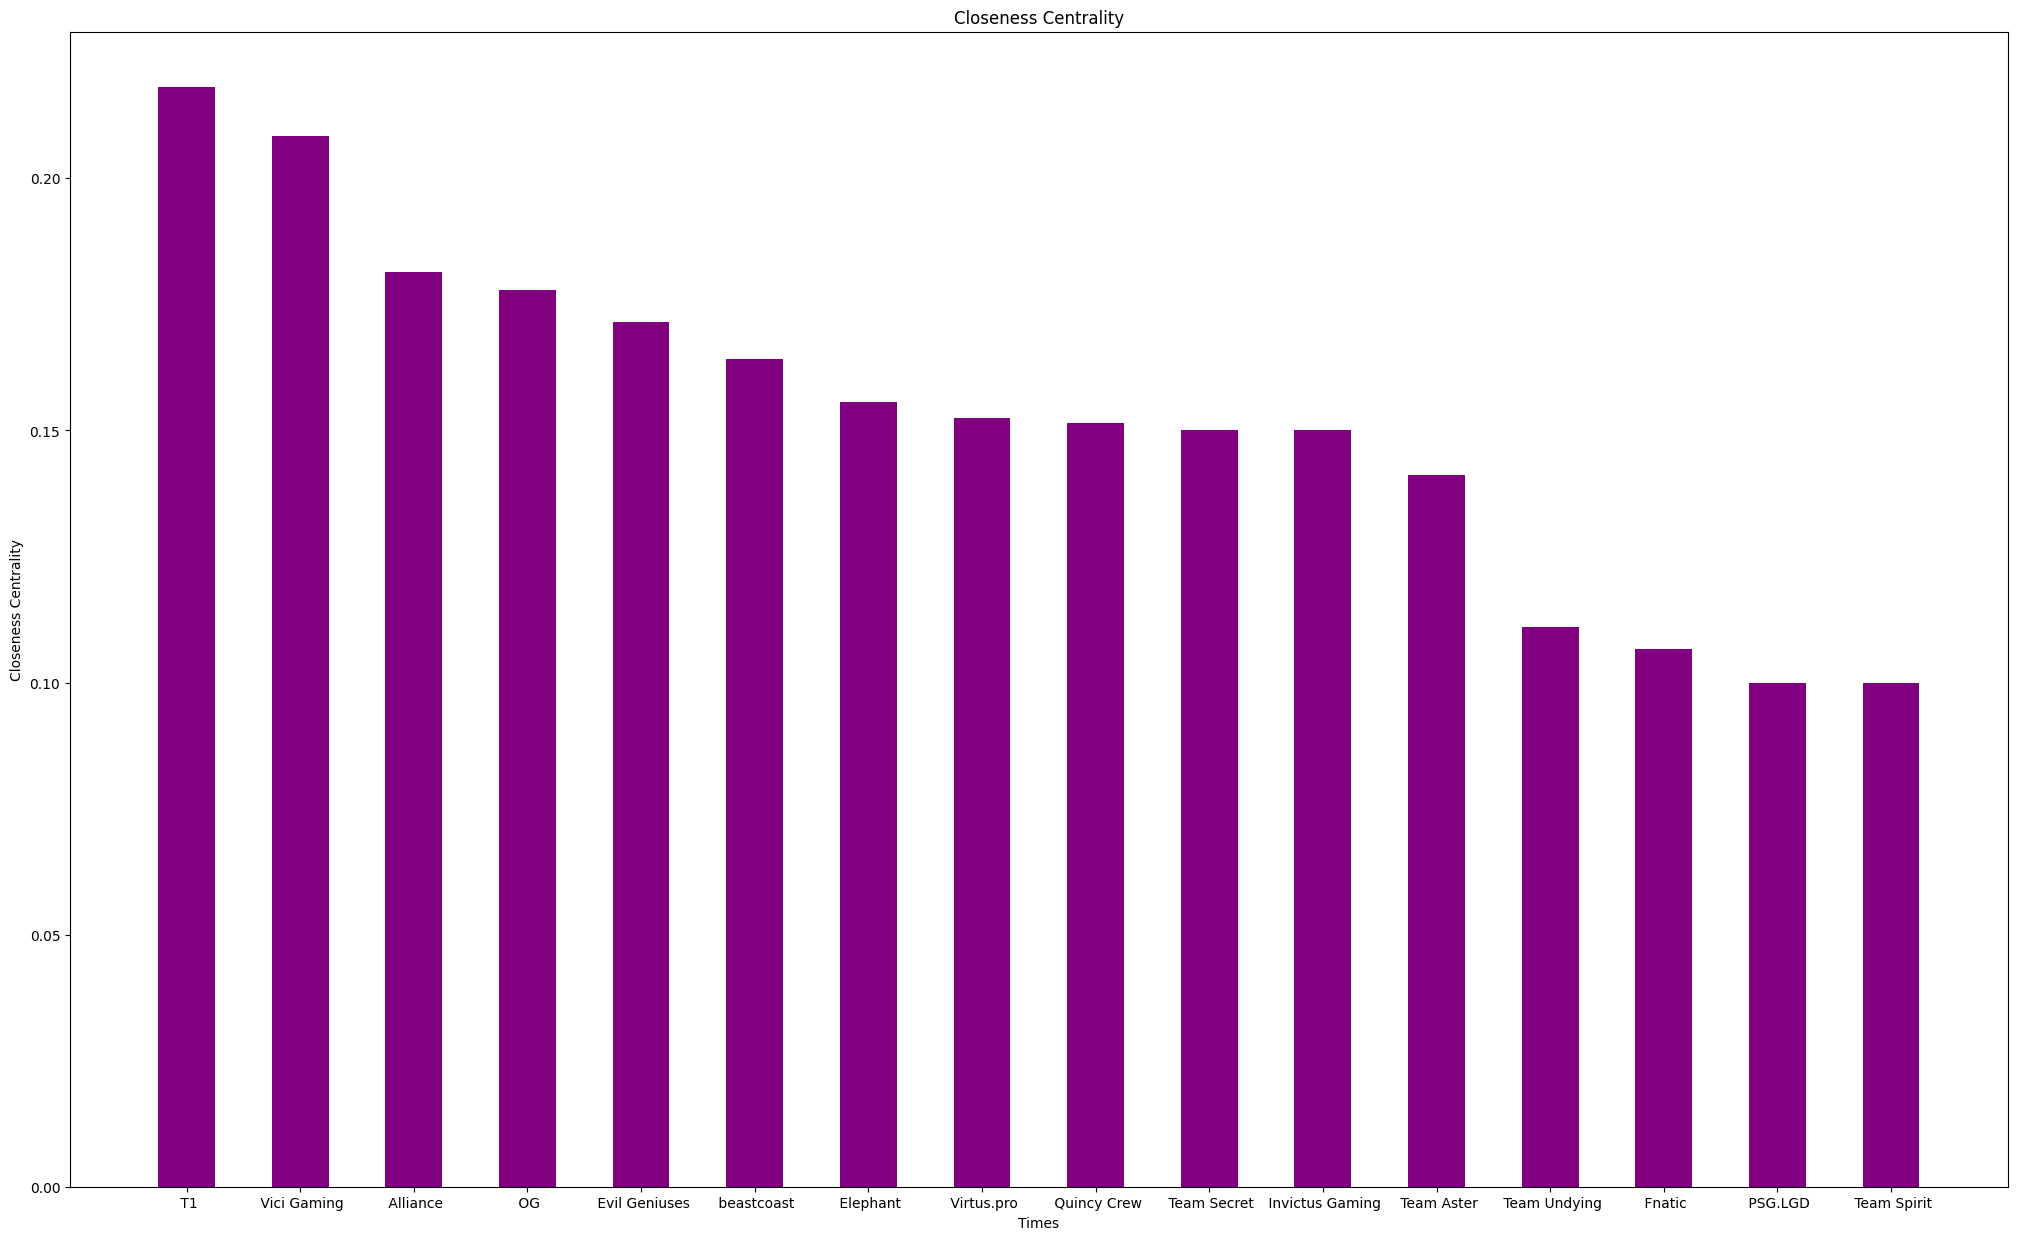

In [ ]:
times = list(closeness_centrality_sorted.keys())
values = list(closeness_centrality_sorted.values())

fig = plt.figure(figsize = (25, 15))

plt.bar(times, values, color = 'purple',
        width = 0.5)

plt.xlabel("Times")
plt.ylabel("Closeness Centrality")
plt.title("Closeness Centrality")
plt.show()

## Degree centrality:
Degree centrality mede o número de conexões que um nó possui.
No contexto do The International 2021, um time com alto grau de centralidade, como o Team Spirit (0.46), jogou mais partidas que outros times. Isso pode indicar que o time teve um bom desempenho e avançou mais no torneio.




In [ ]:
degree_centrality = nx.degree_centrality(G)
degree_centrality_sorted = dict(sorted(degree_centrality.items(), key=lambda item: item[1],reverse=True))

degree_centrality_sorted

{' Team Spirit': 0.4666666666666667,
 ' PSG.LGD': 0.26666666666666666,
 ' Team Secret': 0.26666666666666666,
 ' Invictus Gaming': 0.26666666666666666,
 ' Vici Gaming': 0.26666666666666666,
 ' Virtus.pro': 0.2,
 ' T1': 0.2,
 ' OG': 0.2,
 ' Alliance': 0.13333333333333333,
 ' Quincy Crew': 0.13333333333333333,
 ' Evil Geniuses': 0.13333333333333333,
 ' Fnatic': 0.13333333333333333,
 ' Elephant': 0.06666666666666667,
 ' Team Aster': 0.06666666666666667,
 ' Team Undying': 0.06666666666666667,
 ' beastcoast': 0.06666666666666667}

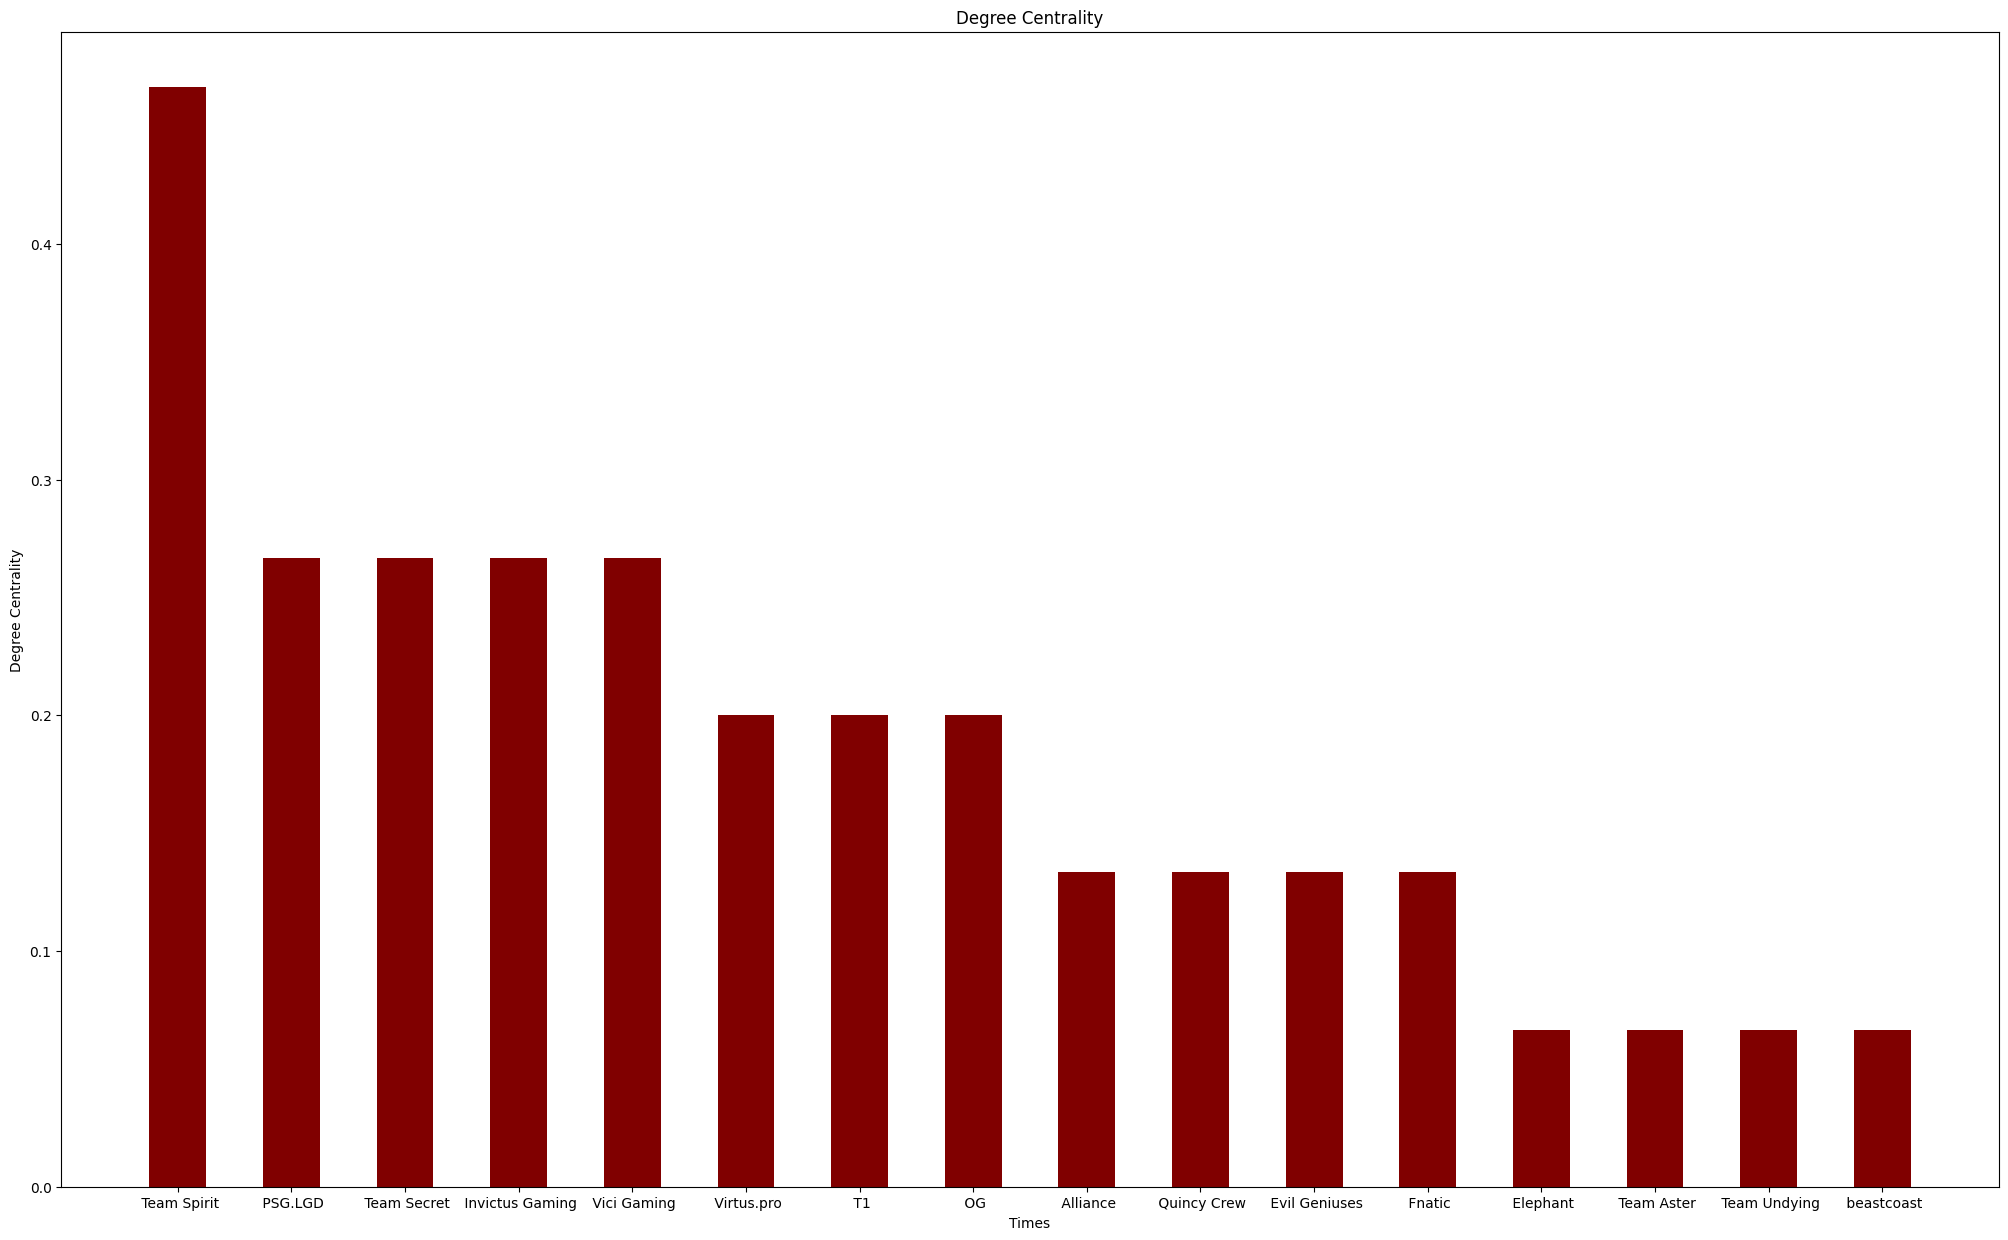

In [ ]:
times = list(degree_centrality_sorted.keys())
values = list(degree_centrality_sorted.values())

fig = plt.figure(figsize = (25, 15))

plt.bar(times, values, color = 'maroon',
        width = 0.5)

plt.xlabel("Times")
plt.ylabel("Degree Centrality")
plt.title("Degree Centrality")
plt.show()

## Betweenness centrality:
Betweenness centrality mede a frequência com que um nó está no caminho mais curto entre dois outros nós.

No contexto do The International 2021, um time com alta betweenness centrality, como o Team Secret (0.31), teve um papel importante na conexão de diferentes partes do torneio.
Isso pode indicar que o time foi um oponente frequente para outros times ou que teve um impacto significativo no resultado do torneio.





In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_sorted = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))

betweenness_centrality_sorted

{' Vici Gaming': 0.09047619047619049,
 ' Invictus Gaming': 0.07380952380952381,
 ' Team Spirit': 0.06666666666666668,
 ' T1': 0.05714285714285715,
 ' OG': 0.0380952380952381,
 ' Alliance': 0.03333333333333334,
 ' Team Secret': 0.03333333333333334,
 ' Evil Geniuses': 0.028571428571428574,
 ' Quincy Crew': 0.02380952380952381,
 ' Virtus.pro': 0.02142857142857143,
 ' Fnatic': 0.01904761904761905,
 ' PSG.LGD': 0.014285714285714287,
 ' Elephant': 0.0,
 ' Team Aster': 0.0,
 ' Team Undying': 0.0,
 ' beastcoast': 0.0}

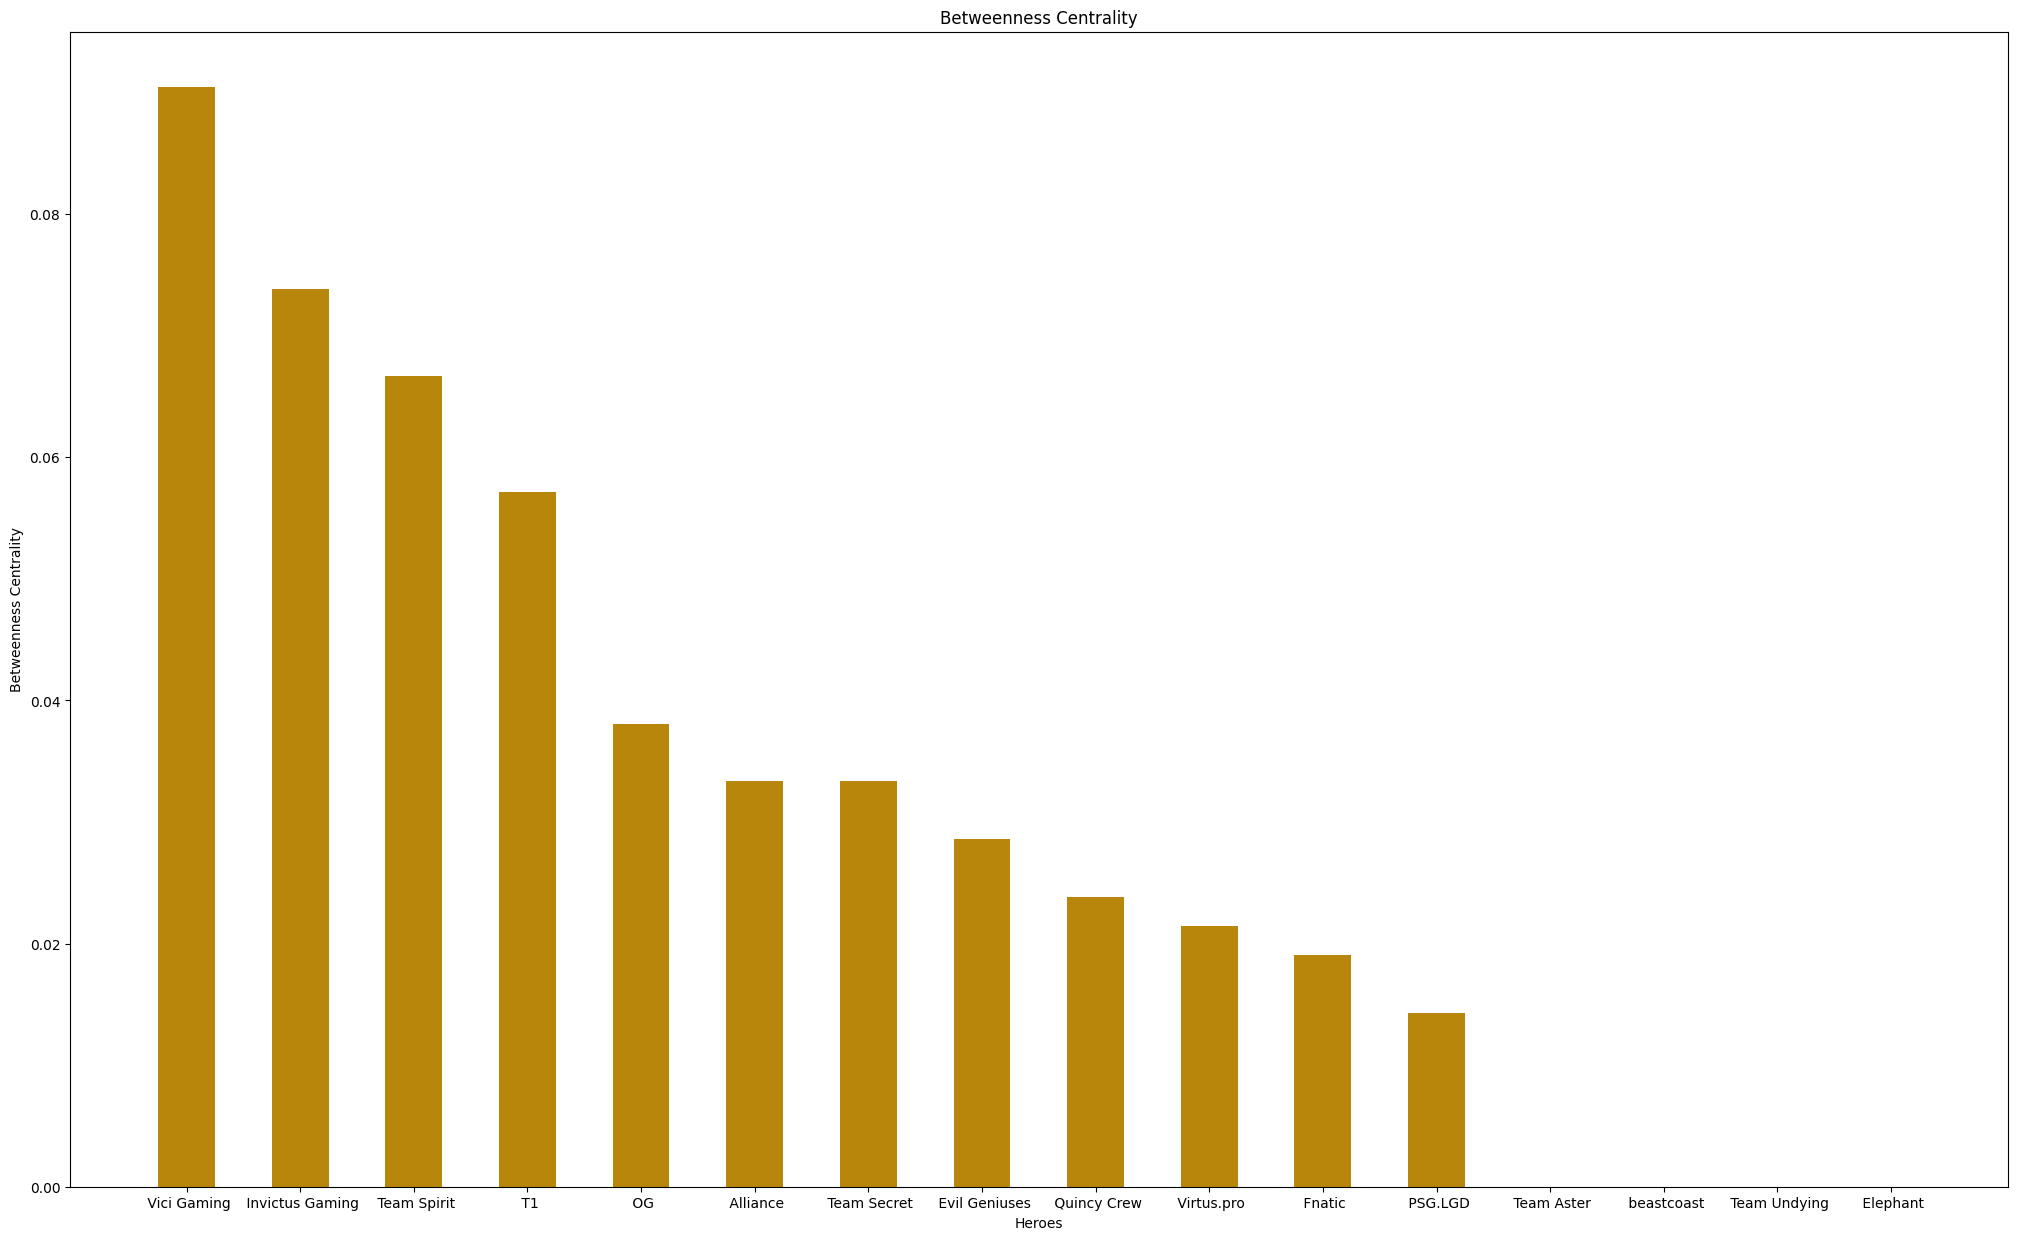

In [ ]:
times = list(betweenness_centrality_sorted.keys())
values = list(betweenness_centrality_sorted.values())

fig = plt.figure(figsize = (25, 15))

plt.bar(times, values, color = 'darkgoldenrod',
        width = 0.5)

plt.xlabel("times")
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness Centrality")
plt.show()

## Comunidades
Quem forma comunidades distintas dentro desta rede?

### Exibindo as comunidades

In [ ]:
communities = community.greedy_modularity_communities(G)
communities

[frozenset({' Invictus Gaming',
            ' OG',
            ' PSG.LGD',
            ' Team Secret',
            ' Team Spirit',
            ' Virtus.pro'}),
 frozenset({' Alliance',
            ' Elephant',
            ' Evil Geniuses',
            ' T1',
            ' Vici Gaming',
            ' beastcoast'}),
 frozenset({' Quincy Crew', ' Team Aster'}),
 frozenset({' Fnatic', ' Team Undying'})]

Cria um dataframe com todas as comunidades e seus respectivos números

In [ ]:
# Create empty dictionary
modularity_class = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number
    for name in community:
        modularity_class[name] = community_number

# Add modularity class to the network as an attribute
nx.set_node_attributes(G, modularity_class, 'modularity_class')

# Make a Pandas dataframe from modularity class network data `G.nodes(data='modularity_class')`
communities_df = pd.DataFrame(G.nodes(data='modularity_class'), columns=['node', 'modularity_class'])
communities_df = communities_df.sort_values(by='modularity_class', ascending=False)

# Show dataframe
communities_df

,node,modularity_class
12,Team Undying,3
13,Fnatic,3
2,Quincy Crew,2
9,Team Aster,2
1,Alliance,1
4,Evil Geniuses,1
6,Elephant,1
7,T1,1
10,Vici Gaming,1
15,beastcoast,1


# Exibição de grafo com Pyvis
Exibição no arquivo .html no repo do GitHub. Lembre-se de ativar a opção 'to' de arrows.

In [ ]:
net = Network(cdn_resources='in_line')
net.from_nx(G)
net.set_edge_smooth('dynamic')
net.toggle_physics(True)
net.show_buttons(filter_=['nodes', 'edges'])


net.generate_html('TI11 Playoffs.html', notebook=False)

'<html>\n    <head>\n        <meta charset="utf-8">\n        \n            <script>function neighbourhoodHighlight(params) {\n  // console.log("in nieghbourhoodhighlight");\n  allNodes = nodes.get({ returnType: "Object" });\n  // originalNodes = JSON.parse(JSON.stringify(allNodes));\n  // if something is selected:\n  if (params.nodes.length > 0) {\n    highlightActive = true;\n    var i, j;\n    var selectedNode = params.nodes[0];\n    var degrees = 2;\n\n    // mark all nodes as hard to read.\n    for (let nodeId in allNodes) {\n      // nodeColors[nodeId] = allNodes[nodeId].color;\n      allNodes[nodeId].color = "rgba(200,200,200,0.5)";\n      if (allNodes[nodeId].hiddenLabel === undefined) {\n        allNodes[nodeId].hiddenLabel = allNodes[nodeId].label;\n        allNodes[nodeId].label = undefined;\n      }\n    }\n    var connectedNodes = network.getConnectedNodes(selectedNode);\n    var allConnectedNodes = [];\n\n    // get the second degree nodes\n    for (i = 1; i < degrees; i++